In [1]:
# VesterAI - Notebook 04: Feature Engineering

"""
Objective:
Prepare the final dataset for modeling by:
- Aggregating daily sentiment signals from multiple sources (Twitter, News, Reddit)
- Merging with daily stock prices
- Generating new features: sentiment ratios, lagged prices, returns, volatility
- Outputting a modeling-ready dataset

Input: /data/processed/
Output: /data/processed/AAPL_model_data.csv
"""

'\nObjective:\nPrepare the final dataset for modeling by:\n- Aggregating daily sentiment signals from multiple sources (Twitter, News, Reddit)\n- Merging with daily stock prices\n- Generating new features: sentiment ratios, lagged prices, returns, volatility\n- Outputting a modeling-ready dataset\n\nInput: /data/processed/\nOutput: /data/processed/AAPL_model_data.csv\n'

In [2]:
!pip install ipywidgets jupyterlab-widgets

import pandas as pd
import numpy as np
import os
from datetime import timedelta

processed_path = "../data/processed"
model_data_path = os.path.join(processed_path, "AAPL_model_data.csv")


Defaulting to user installation because normal site-packages is not writeable


In [3]:
stock_df = pd.read_csv(os.path.join(processed_path, "AAPL_stock_cleaned.csv"))
tweet_df = pd.read_csv(os.path.join(processed_path, "AAPL_twitter_sentiment.csv"))
news_df = pd.read_csv(os.path.join(processed_path, "AAPL_news_sentiment.csv"))

reddit_path = os.path.join(processed_path, "AAPL_reddit_sentiment.csv")
reddit_df = pd.read_csv(reddit_path) if os.path.exists(reddit_path) else pd.DataFrame()

# Convert date to datetime for merging
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
tweet_df["date"] = pd.to_datetime(tweet_df["date"])
news_df["date"] = pd.to_datetime(news_df["date"])
if not reddit_df.empty:
    reddit_df["date"] = pd.to_datetime(reddit_df["date"])

In [4]:
def sentiment_to_score(sentiment):
    return {"positive": 1, "neutral": 0, "negative": -1}.get(sentiment, 0)

# Twitter
tweet_df["score"] = tweet_df["finbert_sentiment"].apply(sentiment_to_score)
daily_twitter = tweet_df.groupby(tweet_df["date"].dt.date)["score"].mean().reset_index()
daily_twitter.columns = ["Date", "twitter_sentiment"]

# News
news_df["score"] = news_df["finbert_sentiment"].apply(sentiment_to_score)
daily_news = news_df.groupby(news_df["date"].dt.date)["score"].mean().reset_index()
daily_news.columns = ["Date", "news_sentiment"]

# Reddit (if available)
if not reddit_df.empty:
    reddit_df["score"] = reddit_df["finbert_sentiment"].apply(sentiment_to_score)
    daily_reddit = reddit_df.groupby(reddit_df["date"].dt.date)["score"].mean().reset_index()
    daily_reddit.columns = ["Date", "reddit_sentiment"]
else:
    daily_reddit = pd.DataFrame(columns=["Date", "reddit_sentiment"])

# Convert to datetime
daily_twitter["Date"] = pd.to_datetime(daily_twitter["Date"])
daily_news["Date"] = pd.to_datetime(daily_news["Date"])
daily_reddit["Date"] = pd.to_datetime(daily_reddit["Date"]) if not daily_reddit.empty else None

In [5]:
merged_df = stock_df.copy()

# Merge sentiment features
merged_df = merged_df.merge(daily_twitter, on="Date", how="left")
merged_df = merged_df.merge(daily_news, on="Date", how="left")
if not daily_reddit.empty:
    merged_df = merged_df.merge(daily_reddit, on="Date", how="left")

# Fill missing sentiment with 0 (neutral)
merged_df[["twitter_sentiment", "news_sentiment", "reddit_sentiment"]] = merged_df[["twitter_sentiment", "news_sentiment", "reddit_sentiment"]].fillna(0)

print("Merged dataset shape:", merged_df.shape)
merged_df.head()

Merged dataset shape: (1313, 9)


,Date,Close,High,Low,Open,Volume,twitter_sentiment,news_sentiment,reddit_sentiment
0,2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400,0.0,0.0,0.0
1,2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800,0.0,0.0,0.0
2,2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200,0.0,0.0,0.0
3,2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000,0.0,0.0,0.0
4,2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200,0.0,0.0,0.0


In [6]:
# Daily returns
merged_df["return"] = merged_df["Close"].pct_change()

# Lagged prices
merged_df["Close_lag1"] = merged_df["Close"].shift(1)
merged_df["return_lag1"] = merged_df["return"].shift(1)

# Rolling features
merged_df["rolling_mean_3"] = merged_df["Close"].rolling(window=3).mean()
merged_df["rolling_vol_3"] = merged_df["return"].rolling(window=3).std()

# Drop NA rows from lagging
merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)
merged_df.head()

,Date,Close,High,Low,Open,Volume,twitter_sentiment,news_sentiment,reddit_sentiment,return,Close_lag1,return_lag1,rolling_mean_3,rolling_vol_3
0,2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000,0.0,0.0,0.0,-0.004703,72.582909,0.007968,72.277863,0.009117
1,2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200,0.0,0.0,0.0,0.016086,72.241554,-0.004703,72.742704,0.010477
2,2020-01-09,74.962807,75.156487,74.132390,74.384173,170108400,0.0,0.0,0.0,0.021241,73.403648,0.016086,73.536003,0.013735
3,2020-01-10,75.132263,75.698794,74.628689,75.197636,140644800,0.0,0.0,0.0,0.002261,74.962807,0.021241,74.499573,0.009815
4,2020-01-13,76.737427,76.764062,75.330800,75.449437,121532000,0.0,0.0,0.0,0.021365,75.132263,0.002261,75.610832,0.010994


In [7]:
merged_df.to_csv(model_data_path, index=False)
print(f"Modeling-ready dataset saved to: {model_data_path}")

Modeling-ready dataset saved to: ../data/processed/AAPL_model_data.csv


In [8]:
print("Feature Engineering Summary:")
print(f"Total records: {merged_df.shape[0]}")
print("Columns:", list(merged_df.columns))
print("\nNext: Train models to forecast returns or sentiment-movement impact in Notebook 05.")

Feature Engineering Summary:
Total records: 1310
Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'twitter_sentiment', 'news_sentiment', 'reddit_sentiment', 'return', 'Close_lag1', 'return_lag1', 'rolling_mean_3', 'rolling_vol_3']

Next: Train models to forecast returns or sentiment-movement impact in Notebook 05.


In [9]:
# Install ta for technical indicators
!pip install ta --quiet

In [10]:
import ta

In [11]:
# Apply technical indicators using 'ta' package
def add_technical_indicators(df):
    # Price-based indicators
    df["rsi_14"] = ta.momentum.RSIIndicator(close=df["Close"], window=14).rsi()
    df["macd"] = ta.trend.MACD(close=df["Close"]).macd()
    df["macd_signal"] = ta.trend.MACD(close=df["Close"]).macd_signal()
    df["ema_12"] = ta.trend.EMAIndicator(close=df["Close"], window=12).ema_indicator()
    df["ema_26"] = ta.trend.EMAIndicator(close=df["Close"], window=26).ema_indicator()
    
    # Bollinger Bands
    boll = ta.volatility.BollingerBands(close=df["Close"])
    df["bollinger_h"] = boll.bollinger_hband()
    df["bollinger_l"] = boll.bollinger_lband()
    df["bollinger_m"] = boll.bollinger_mavg()

    # Volume-based indicators
    df["obv"] = ta.volume.OnBalanceVolumeIndicator(close=df["Close"], volume=df["Volume"]).on_balance_volume()

    return df

# Apply to merged_df
merged_df = add_technical_indicators(merged_df)

# Drop rows with NaN introduced by long rolling windows
merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

print("Technical indicators added.")
merged_df[["Close", "rsi_14", "macd", "bollinger_h", "obv"]].head()

Technical indicators added.


,Close,rsi_14,macd,bollinger_h,obv
0,69.910980,30.770217,-0.372241,81.620885,-82898400
1,71.020020,35.233280,-0.721815,82.003643,115156400
2,66.377571,27.299508,-1.357810,82.960093,-205449200
3,66.338745,27.244254,-1.843720,83.460116,-631959200
4,72.514908,45.975879,-1.710722,83.440705,-290562000


In [12]:
# Save updated dataset with technical indicators
model_data_path = os.path.join(processed_path, "AAPL_model_data.csv")
merged_df.to_csv(model_data_path, index=False)
print(f"Updated dataset saved with technical indicators: {model_data_path}")

Updated dataset saved with technical indicators: ../data/processed/AAPL_model_data.csv


In [13]:
print("Feature Engineering Summary (Extended):")
print(f"Records: {merged_df.shape[0]}")
print("Features added:", [col for col in merged_df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

Feature Engineering Summary (Extended):
Records: 1277
Features added: ['twitter_sentiment', 'news_sentiment', 'reddit_sentiment', 'return', 'Close_lag1', 'return_lag1', 'rolling_mean_3', 'rolling_vol_3', 'rsi_14', 'macd', 'macd_signal', 'ema_12', 'ema_26', 'bollinger_h', 'bollinger_l', 'bollinger_m', 'obv']


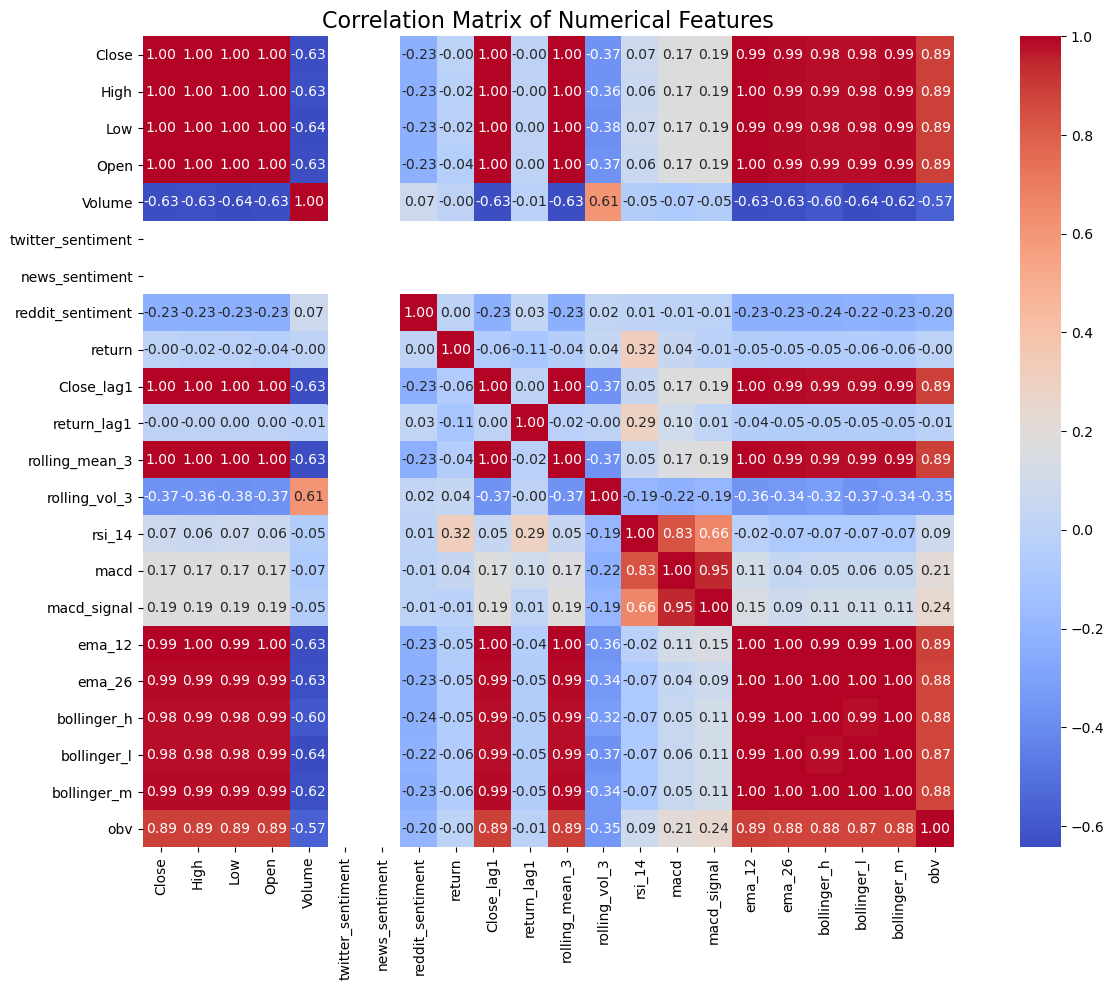

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical features for correlation
numerical_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns
correlation_matrix = merged_df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Define target: Predicting next day's return (we'll build this in modeling notebook)
# So we check correlation with today's return
target_corr = correlation_matrix["return"].drop("return").sort_values(ascending=False)

# Display top positive and negative correlations
print("Top positively correlated features with return:")
print(target_corr.head(5))

print("\nTop negatively correlated features with return:")
print(target_corr.tail(5))

Top positively correlated features with return:
rsi_14              0.318111
macd                0.044867
rolling_vol_3       0.037550
reddit_sentiment    0.002024
Volume             -0.000486
Name: return, dtype: float64

Top negatively correlated features with return:
bollinger_l         -0.055275
Close_lag1          -0.061927
return_lag1         -0.108349
twitter_sentiment         NaN
news_sentiment            NaN
Name: return, dtype: float64


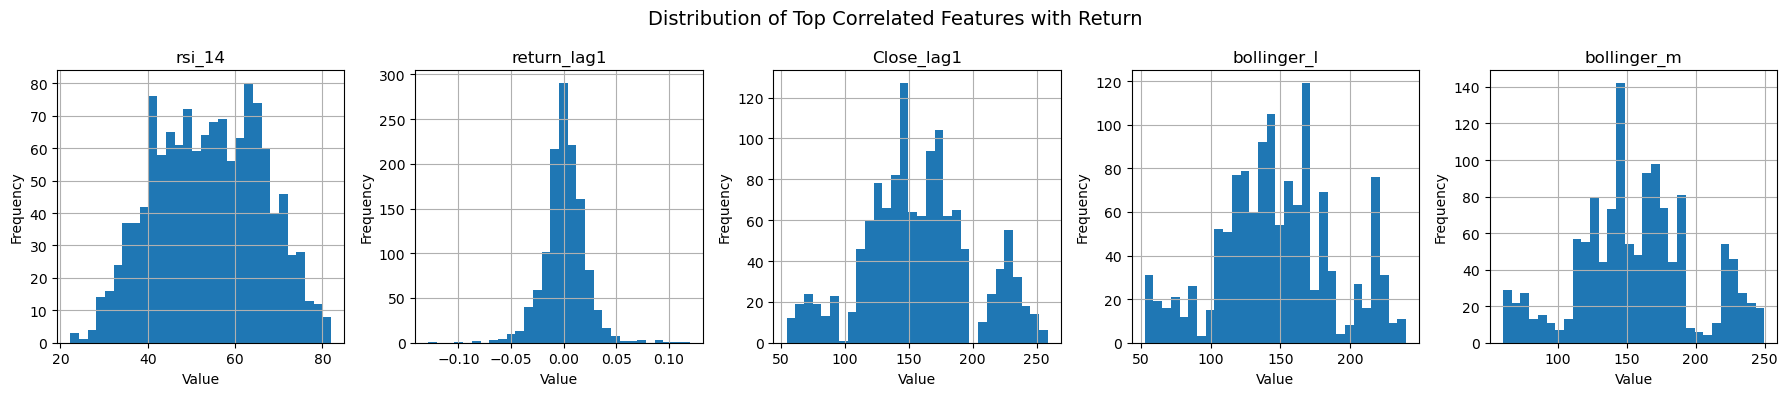

In [16]:
# Select top 5 correlated features with return
top_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Manually plot each feature
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(top_features), figsize=(18, 4))

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    merged_df[feature].hist(bins=30, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.suptitle("Distribution of Top Correlated Features with Return", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
# Save feature correlation info for documentation or later analysis
target_corr.to_csv(os.path.join(processed_path, "feature_correlation.csv"))
print("Correlation with return saved to: feature_correlation.csv")

Correlation with return saved to: feature_correlation.csv


In [18]:
print("Exploration Summary:")
print(f"- Most correlated feature with returns: {target_corr.idxmax()} ({target_corr.max():.3f})")
print(f"- Least correlated feature: {target_corr.idxmin()} ({target_corr.min():.3f})")

print("\nNext: Use this insight to select features for regression/classification in Notebook 05.")

Exploration Summary:
- Most correlated feature with returns: rsi_14 (0.318)
- Least correlated feature: return_lag1 (-0.108)

Next: Use this insight to select features for regression/classification in Notebook 05.
